# Replica Exchange (Parallel Tempering)

This notebook demonstrates the theory and implementation of replica exchange, also known as parallel tempering. Replica exchange is a powerful extension of simulated annealing that significantly improves global optimization by running multiple "replicas" at different temperatures simultaneously.

## 1. Introduction

### 1.1 The Challenge with Single-Temperature Annealing

Standard simulated annealing (see `01-simulated_annealing.ipynb`) can get trapped in local optima, especially when:
- The energy landscape has many local minima
- Temperature cools too quickly
- Initial conditions are unfavorable

### 1.2 The Replica Exchange Solution

Replica exchange addresses this by:
1. Running multiple copies (replicas) of the system at different temperatures
2. Periodically attempting to exchange configurations between replicas
3. Allowing good solutions to "filter down" to lower temperatures for refinement
4. Enabling trapped solutions at low temperature to escape via high-temperature exploration

## 2. Theory: How Replica Exchange Works

In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')

from hill_climber import HillClimber, TemperatureLadder

# Set random seed for reproducibility
np.random.seed(42)

### 2.1 Temperature Ladder

Replicas are assigned temperatures from a "ladder" - a carefully chosen sequence from cold to hot.

**Geometric Spacing** (recommended):
$$T_i = T_{\text{min}} \times \left(\frac{T_{\text{max}}}{T_{\text{min}}}\right)^{\frac{i}{N-1}}$$

**Linear Spacing**:
$$T_i = T_{\text{min}} + \frac{i}{N-1}(T_{\text{max}} - T_{\text{min}})$$

Geometric spacing typically provides better exchange acceptance rates.

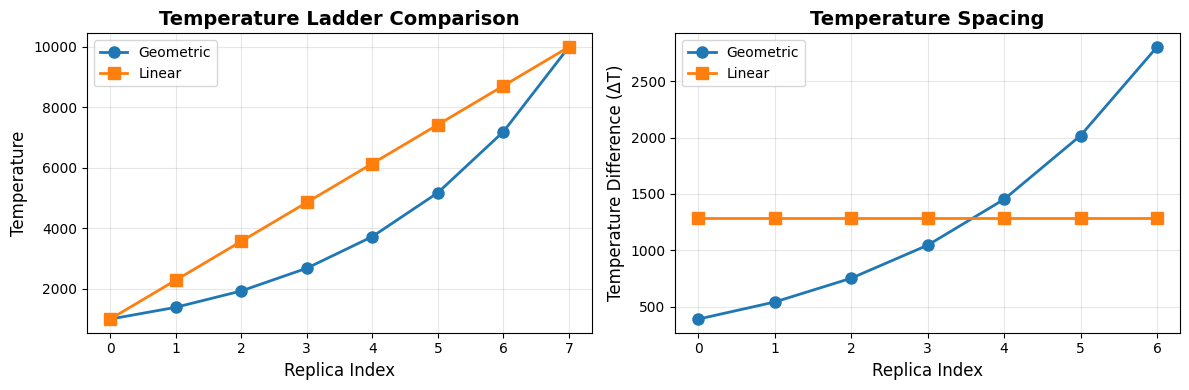

Geometric ladder: [ 1000.          1389.49549437  1930.69772888  2682.69579528
  3727.59372031  5179.47467923  7196.85673001 10000.        ]
Linear ladder:    [ 1000.          2285.71428571  3571.42857143  4857.14285714
  6142.85714286  7428.57142857  8714.28571429 10000.        ]


In [2]:
# Compare temperature ladder schemes
n_replicas = 8
T_min = 1000
T_max = 10000

geometric_ladder = TemperatureLadder.geometric(n_replicas, T_min, T_max)
linear_ladder = TemperatureLadder.linear(n_replicas, T_min, T_max)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Temperature values
ax1.plot(range(n_replicas), geometric_ladder.temperatures, 'o-', label='Geometric', linewidth=2, markersize=8)
ax1.plot(range(n_replicas), linear_ladder.temperatures, 's-', label='Linear', linewidth=2, markersize=8)
ax1.set_xlabel('Replica Index', fontsize=12)
ax1.set_ylabel('Temperature', fontsize=12)
ax1.set_title('Temperature Ladder Comparison', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Temperature spacing (differences)
geom_diff = np.diff(geometric_ladder.temperatures)
lin_diff = np.diff(linear_ladder.temperatures)
ax2.plot(range(n_replicas-1), geom_diff, 'o-', label='Geometric', linewidth=2, markersize=8)
ax2.plot(range(n_replicas-1), lin_diff, 's-', label='Linear', linewidth=2, markersize=8)
ax2.set_xlabel('Replica Index', fontsize=12)
ax2.set_ylabel('Temperature Difference (ΔT)', fontsize=12)
ax2.set_title('Temperature Spacing', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Geometric ladder:", geometric_ladder.temperatures)
print("Linear ladder:   ", linear_ladder.temperatures)

### 2.2 The Exchange Process

Periodically, adjacent replicas attempt to exchange their **configurations** (not temperatures!).

**Exchange Probability** (Metropolis criterion):
$$P(\text{exchange}) = \min\left(1, e^{\Delta E \cdot \Delta\beta}\right)$$

where:
- $\Delta E = E_2 - E_1$ (energy difference)
- $\Delta\beta = \frac{1}{T_1} - \frac{1}{T_2}$ (inverse temperature difference)
- For maximization: $E = -\text{objective}$

**Key insight**: Better solutions tend to move to lower temperatures, while high temperatures continue broad exploration.

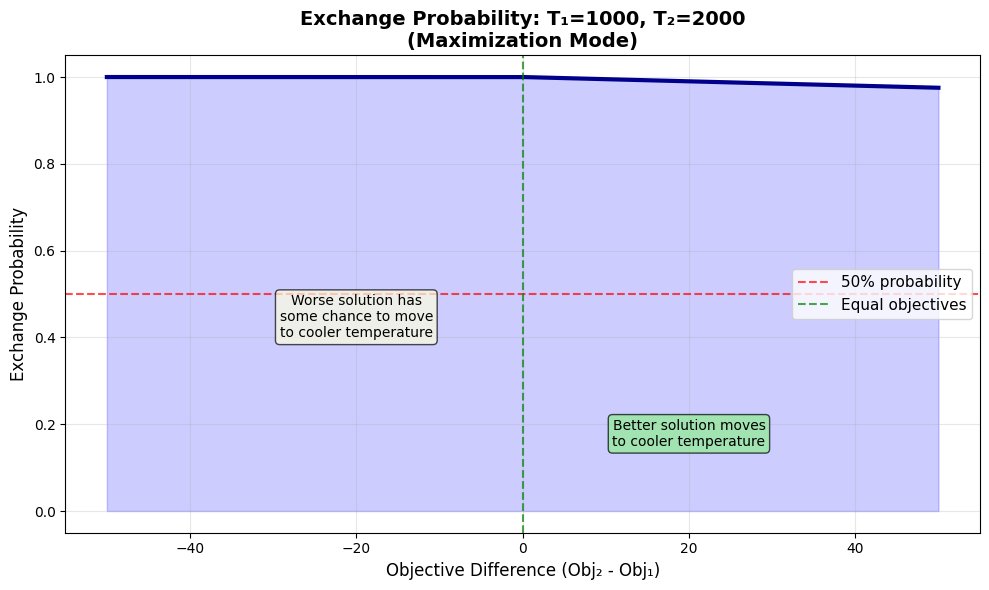

In [3]:
from hill_climber.replica_exchange import compute_exchange_probability

# Visualize exchange probabilities
T1 = 1000  # Cooler replica
T2 = 2000  # Hotter replica

# Range of objective value differences
obj_diffs = np.linspace(-50, 50, 200)
obj1 = 100  # Base objective for replica 1

probs = [compute_exchange_probability(obj1, obj1 + diff, T1, T2, 'maximize') 
         for diff in obj_diffs]

plt.figure(figsize=(10, 6))
plt.plot(obj_diffs, probs, linewidth=3, color='darkblue')
plt.axhline(y=0.5, color='red', linestyle='--', label='50% probability', alpha=0.7)
plt.axvline(x=0, color='green', linestyle='--', label='Equal objectives', alpha=0.7)
plt.fill_between(obj_diffs, 0, probs, alpha=0.2, color='blue')
plt.xlabel('Objective Difference (Obj₂ - Obj₁)', fontsize=12)
plt.ylabel('Exchange Probability', fontsize=12)
plt.title(f'Exchange Probability: T₁={T1}, T₂={T2}\n(Maximization Mode)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(-0.05, 1.05)

# Add annotations
plt.annotate('Better solution moves\nto cooler temperature', 
             xy=(20, 0.15), fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
plt.annotate('Worse solution has\nsome chance to move\nto cooler temperature', 
             xy=(-20, 0.4), fontsize=10, ha='center',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.show()

### 2.3 Exchange Strategies

Different strategies for selecting which replica pairs to attempt exchanges:

1. **even_odd** (default): Alternates between even pairs (0-1, 2-3, ...) and odd pairs (1-2, 3-4, ...)
   - Good balance of thoroughness and efficiency
   - Prevents deadlocks
   
2. **random**: Randomly select pairs each round
   - More stochastic exploration
   - Can help in some difficult landscapes
   
3. **all_neighbors**: All adjacent pairs attempt exchange each round
   - Most thorough mixing
   - Higher computational cost

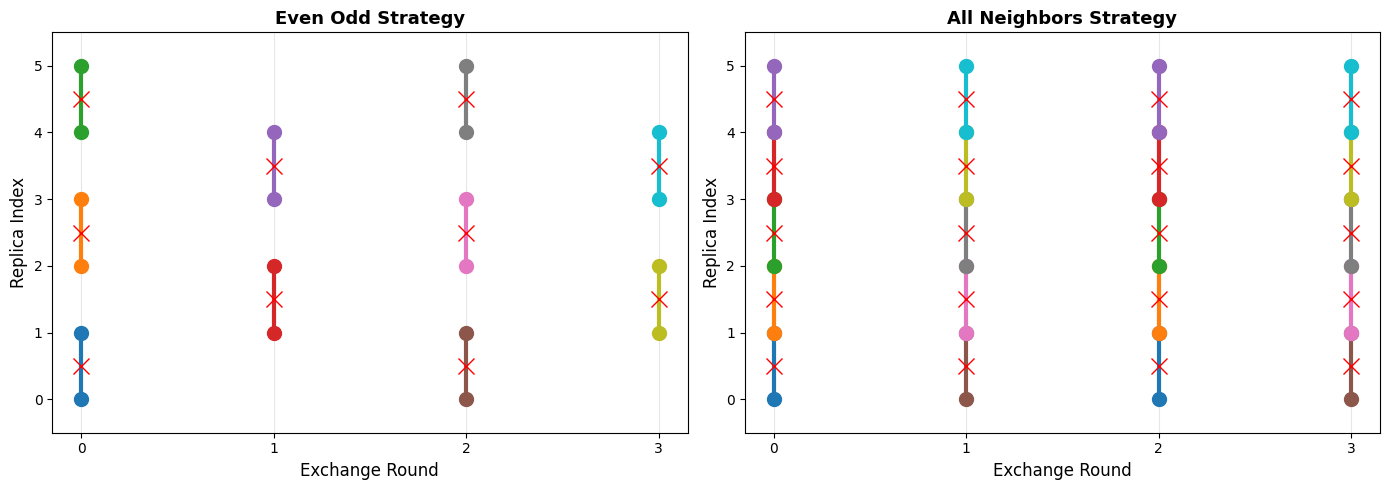


Exchange pairs by round:

even_odd:
  Round 0: [(0, 1), (2, 3), (4, 5)]
  Round 1: [(1, 2), (3, 4)]
  Round 2: [(0, 1), (2, 3), (4, 5)]
  Round 3: [(1, 2), (3, 4)]

all_neighbors:
  Round 0: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
  Round 1: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
  Round 2: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
  Round 3: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


In [4]:
from hill_climber.replica_exchange import ExchangeScheduler

# Demonstrate exchange strategies
n_replicas = 6
n_rounds = 4

strategies = ['even_odd', 'all_neighbors']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, strategy in zip(axes, strategies):
    scheduler = ExchangeScheduler(n_replicas, strategy)
    
    # Collect pairs for multiple rounds
    rounds_data = []
    for round_num in range(n_rounds):
        pairs = scheduler.get_pairs()
        rounds_data.append(pairs)
    
    # Visualize as matrix
    for round_num, pairs in enumerate(rounds_data):
        for i, j in pairs:
            ax.plot([round_num, round_num], [i, j], 'o-', linewidth=3, markersize=10)
            ax.plot([round_num], [(i+j)/2], 'x', markersize=12, color='red')
    
    ax.set_xlabel('Exchange Round', fontsize=12)
    ax.set_ylabel('Replica Index', fontsize=12)
    ax.set_title(f'{strategy.replace("_", " ").title()} Strategy', fontsize=13, fontweight='bold')
    ax.set_yticks(range(n_replicas))
    ax.set_xticks(range(n_rounds))
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_ylim(-0.5, n_replicas - 0.5)

plt.tight_layout()
plt.show()

print("\nExchange pairs by round:")
for strategy in strategies:
    print(f"\n{strategy}:")
    scheduler = ExchangeScheduler(n_replicas, strategy)
    for round_num in range(n_rounds):
        pairs = scheduler.get_pairs()
        print(f"  Round {round_num}: {pairs}")

## 3. Practical Example: Correlation Optimization

Let's use replica exchange to optimize a simple 2D correlation objective.

In [5]:
# Create initial random data
data = pd.DataFrame({
    'x': np.random.rand(100),
    'y': np.random.rand(100)
})

# Define objective: maximize absolute correlation
def objective_high_correlation(x, y):
    """Maximize Pearson correlation."""
    corr = pd.Series(x).corr(pd.Series(y))
    metrics = {'Pearson correlation': corr}
    return metrics, abs(corr)

# Create optimizer with replica exchange
climber = HillClimber(
    data=data,
    objective_func=objective_high_correlation,
    max_time=0.5,  # 30 seconds
    mode='maximize',
    n_replicas=4,
    temperature=1000,
    T_max=10000,
    temperature_scheme='geometric',
    exchange_interval=100,
    exchange_strategy='even_odd'
)

# Run optimization
print("Running replica exchange optimization...\n")
best_data, history_df = climber.climb()

print(f"\nFinal correlation: {history_df['Pearson correlation'].iloc[-1]:.4f}")
print(f"Improvement: {history_df['Pearson correlation'].iloc[-1] - history_df['Pearson correlation'].iloc[0]:.4f}")

Running replica exchange optimization...

Starting replica exchange with 4 replicas...
Temperature ladder: [ 1000.          2154.43469003  4641.58883361 10000.        ]

Best result from replica 3 (T=9790.1)
Exchange acceptance rate: 100.00%

Final correlation: 0.0747
Improvement: 0.1087

Best result from replica 3 (T=9790.1)
Exchange acceptance rate: 100.00%

Final correlation: 0.0747
Improvement: 0.1087


### 3.1 Visualize Optimization Progress

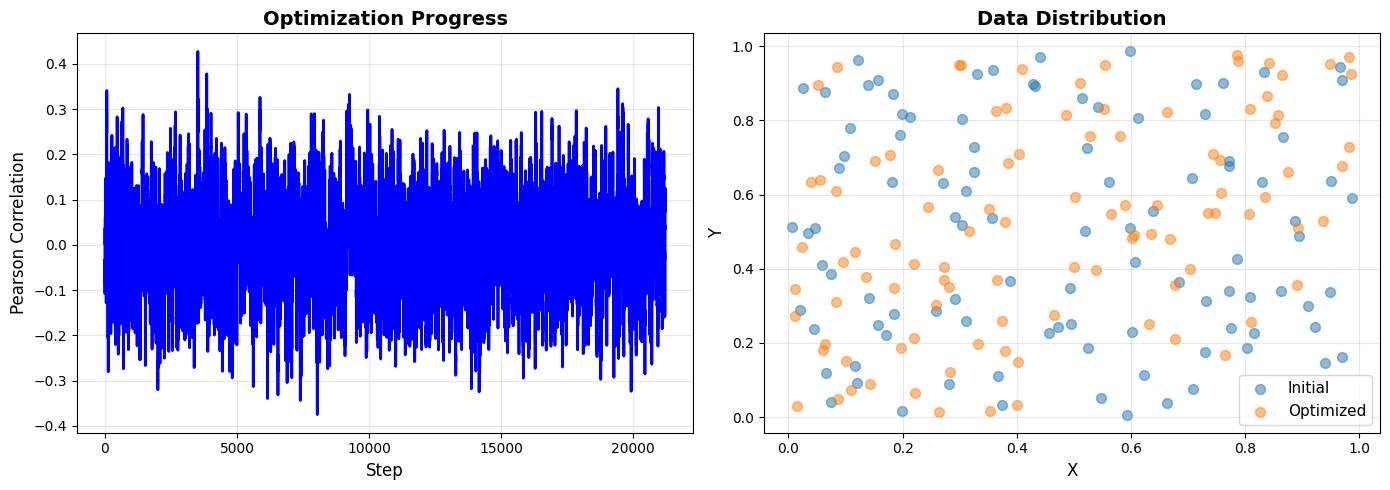

In [6]:
# Plot optimization progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Progress plot
ax1.plot(history_df['Step'], history_df['Pearson correlation'], linewidth=2, color='blue')
ax1.set_xlabel('Step', fontsize=12)
ax1.set_ylabel('Pearson Correlation', fontsize=12)
ax1.set_title('Optimization Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Before/after scatter
ax2.scatter(data['x'], data['y'], alpha=0.5, label='Initial', s=50)
ax2.scatter(best_data['x'], best_data['y'], alpha=0.5, label='Optimized', s=50)
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_title('Data Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Comparing Configurations

Let's compare different replica exchange configurations to see their effects.


Testing 2 replicas...
Starting replica exchange with 2 replicas...
Temperature ladder: [ 1000. 10000.]

Best result from replica 0 (T=978.9)
Exchange acceptance rate: 100.00%

Testing 4 replicas...
Starting replica exchange with 4 replicas...
Temperature ladder: [ 1000.          2154.43469003  4641.58883361 10000.        ]

Best result from replica 0 (T=978.9)
Exchange acceptance rate: 100.00%

Testing 4 replicas...
Starting replica exchange with 4 replicas...
Temperature ladder: [ 1000.          2154.43469003  4641.58883361 10000.        ]

Best result from replica 1 (T=2131.7)
Exchange acceptance rate: 100.00%

Testing 8 replicas...
Starting replica exchange with 8 replicas...
Temperature ladder: [ 1000.          1389.49549437  1930.69772888  2682.69579528
  3727.59372031  5179.47467923  7196.85673001 10000.        ]

Best result from replica 1 (T=2131.7)
Exchange acceptance rate: 100.00%

Testing 8 replicas...
Starting replica exchange with 8 replicas...
Temperature ladder: [ 1000.

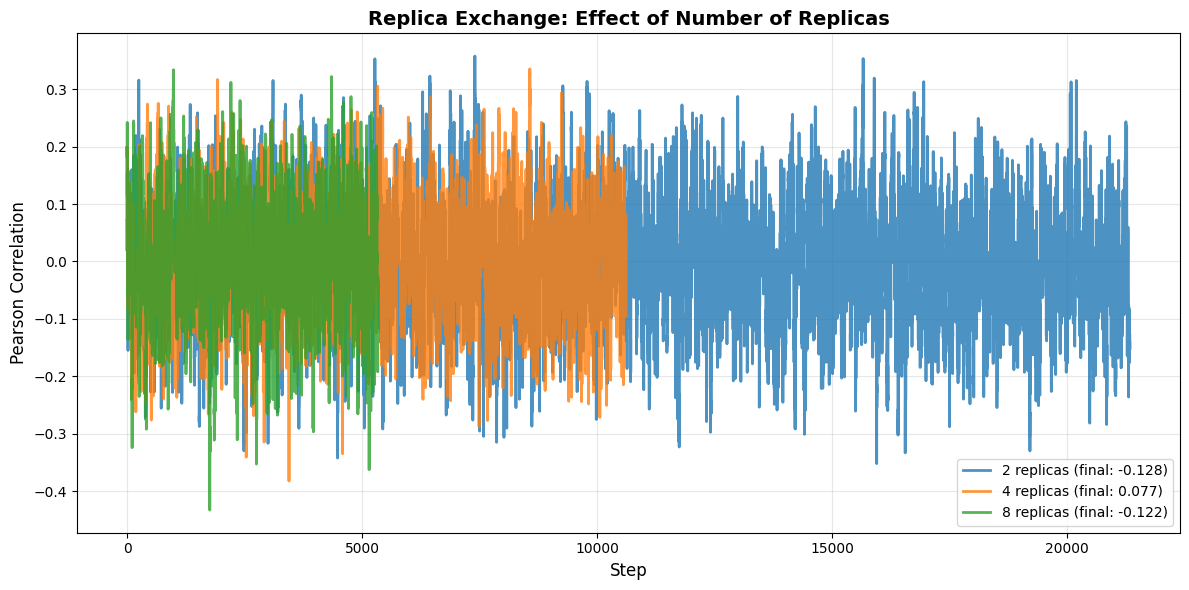


Final Results:
2 replicas     : -0.1284
4 replicas     : 0.0770
8 replicas     : -0.1224


In [7]:
# Compare different numbers of replicas
configurations = [
    {'n_replicas': 2, 'label': '2 replicas'},
    {'n_replicas': 4, 'label': '4 replicas'},
    {'n_replicas': 8, 'label': '8 replicas'},
]

results = []

for config in configurations:
    # Reset data
    test_data = pd.DataFrame({
        'x': np.random.rand(100),
        'y': np.random.rand(100)
    })
    
    climber = HillClimber(
        data=test_data,
        objective_func=objective_high_correlation,
        max_time=0.25,  # 15 seconds
        mode='maximize',
        n_replicas=config['n_replicas'],
        temperature=1000,
        T_max=10000
    )
    
    print(f"\nTesting {config['label']}...")
    best_data, history_df = climber.climb()
    
    results.append({
        'config': config['label'],
        'history': history_df,
        'final_corr': history_df['Pearson correlation'].iloc[-1]
    })

# Plot comparison
plt.figure(figsize=(12, 6))
for r in results:
    plt.plot(r['history']['Step'], r['history']['Pearson correlation'], 
             linewidth=2, label=f"{r['config']} (final: {r['final_corr']:.3f})", alpha=0.8)

plt.xlabel('Step', fontsize=12)
plt.ylabel('Pearson Correlation', fontsize=12)
plt.title('Replica Exchange: Effect of Number of Replicas', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nFinal Results:")
for r in results:
    print(f"{r['config']:15s}: {r['final_corr']:.4f}")

## 5. Key Takeaways

### Advantages of Replica Exchange:
1. **Better global optimization** - Multiple temperatures explore different regions
2. **Escape local minima** - Hot replicas can escape traps, share solutions with cold replicas
3. **Automatic tuning** - Less sensitive to initial temperature choice
4. **Parallel efficiency** - All replicas work simultaneously

### Configuration Guidelines:
- **Number of replicas**: 4-8 is typically sufficient; more helps with difficult landscapes
- **Temperature range**: $T_{\text{max}}$ should be 5-10× $T_{\text{min}}$ for good exchange rates
- **Temperature scheme**: Geometric spacing generally works better than linear
- **Exchange interval**: 50-200 steps balances mixing with computational cost
- **Exchange strategy**: `even_odd` is a good default

### Monitoring Performance:
- **Exchange acceptance rate**: Typically 10-40% is good
  - Too low: Increase overlap (more replicas or smaller $T_{\text{max}}$)
  - Too high: Temperatures might be too similar
- **Best replica**: Usually (but not always) the coldest replica

## Next Steps

Continue to:
- `01-simulated_annealing.ipynb` - Learn about basic simulated annealing
- `02-pearson_spearman.ipynb` - Apply to multi-objective correlation optimization
- `03-mean_std.ipynb` - Create distributions with matching statistics
- Other example notebooks for more complex applications